In [1]:
import sys
sys.path.append('../')
from Attacked_Model.autoencoder_BATADAL import load_AEED
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score
import pickle
from sklearn.preprocessing import MinMaxScaler
import numpy as np
att_data = pd.read_csv('../Data/BATADAL/attack_10_from_test_dataset.csv')

# define the column sets for the pandas dataframes
xset = [col for col in att_data.columns if col not in ['Unnamed: 0', 'DATETIME', 'ATT_FLAG']]
yset = ['ATT_FLAG']

autoencoder = load_AEED("../Attacked_Model/BATADAL/autoencoder.json", "../Attacked_Model/BATADAL/autoencoder.h5")
scaler = pickle.load(open("../Attacked_Model/BATADAL/scaler.p", "rb"))
with open("../Attacked_Model/BATADAL/theta") as f:
        theta = float(f.read())
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 

Using TensorFlow backend.


../Attacked_Model/BATADAL/autoencoder.h5


/home/alessando/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/alessando/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [2]:
def compute_scores(Y, Yhat):
    return [accuracy_score(Y, Yhat), f1_score(Y, Yhat), precision_score(Y, Yhat), recall_score(Y, Yhat)]#, fpr[0]]

# Evaluate Constrained attack over X dimension

In [3]:
results_mean_replay = {new_list: 0 for new_list in [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,43]}
results_mean_white = {new_list: 0 for new_list in [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,43]}
results_mean_black = {new_list: 0 for new_list in [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,43]}
sum_orig = 0

for i in range(1,15):
    df_test_01 = pd.read_csv('../Data/BATADAL/attack_'+str(i)+'_from_test_dataset.csv', parse_dates = ['DATETIME'], dayfirst=True)
    X3 = pd.DataFrame(index=df_test_01.index, columns=xset,
                      data=scaler.transform(df_test_01[xset]))    
    Y3 = [1]*len(X3)
    Yhat3, _, _, _ = autoencoder.detect(X3, theta=theta, window=3, average=True)
    results_orig = pd.DataFrame(
                           columns=['accuracy', 'f1_score', 'precision', 'recall'])#,'fpr'])
    results_orig.loc['orig'] = compute_scores(Y3, Yhat3)
    sum_orig = sum_orig + results_orig.loc['orig'].at['accuracy']
    results_replay = {}
    results_white = {}
    results_black = {}
    for max_concealeble_variables in [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,43]:
        
            replay = pd.read_csv('../Adversarial_Attacks/Replay_Attack/results/BATADAL/attack_'+str(i)+
                                        '_replay_max_'+str(max_concealeble_variables)+'.csv', dayfirst=True)
            if not(max_concealeble_variables == 43):
                
                white_box = pd.read_csv('../Adversarial_Attacks/Whitebox_Attack/results/BATADAL/max_constraints_fixed/whitebox_attack_'+str(i)+
                                        '_from_test_dataset_max_'+str(max_concealeble_variables)+'.csv', dayfirst=True)
                black_box = pd.read_csv('../Adversarial_Attacks/Black_Box_Attack/results/BATADAL/AE_max_concealable_var_'+
                                        str(max_concealeble_variables)+
                                        '/new_advAE_attack_'+str(i)+'_from_test_dataset_max'+str(max_concealeble_variables)+'.csv', dayfirst=True)
            else:
                
                white_box = pd.read_csv('../Adversarial_Attacks/Whitebox_Attack/results/BATADAL/unconstrained_attack/new_improved_whitebox_attack_'+str(i)+'_from_test_dataset.csv', dayfirst=True)
                black_box = pd.read_csv('../Adversarial_Attacks/Black_Box_Attack/results/BATADAL/unconstrained_attack/new_advAE_attack_'+str(i)+'_from_test_dataset.csv', dayfirst=True)
            
            replay = pd.DataFrame(index=replay.index, columns=xset,
                      data=scaler.transform(replay[xset]))
            white_box = pd.DataFrame(index=white_box.index, columns=xset,
                      data=scaler.transform(white_box[xset]))
            black_box = pd.DataFrame(index=black_box.index, columns=xset,
                      data=scaler.transform(black_box[xset]))
            
            Y4 = [1]*len(replay)
            Y5 = [1]*len(white_box)
            Y6 = [1]*len(black_box)
            
            Yhat4, _, _, _ = autoencoder.detect(replay, theta=theta, window=3, average=True)
            Yhat5, _, _, _ = autoencoder.detect(white_box, theta=theta, window=3, average=True)
            Yhat6, _, _, _ = autoencoder.detect(black_box, theta=theta, window=3, average=True)
            
            results = pd.DataFrame(
                           columns=['accuracy', 'f1_score', 'precision', 'recall'])#,'fpr'])
            results.loc['replay'] = compute_scores(Y4, Yhat4)
            results.loc['iterative'] = compute_scores(Y5, Yhat5)
            results.loc['learning'] = compute_scores(Y6, Yhat6)
            
            results_replay[max_concealeble_variables] = results.loc['replay'].at['recall']
            results_white[max_concealeble_variables] = results.loc['iterative'].at['recall']
            results_black[max_concealeble_variables] = results.loc['learning'].at['recall']  
            
            results_mean_replay[max_concealeble_variables] = results_mean_replay[max_concealeble_variables] + results_replay[max_concealeble_variables]
            results_mean_white[max_concealeble_variables] = results_mean_white[max_concealeble_variables] + results_white[max_concealeble_variables]
            results_mean_black[max_concealeble_variables] = results_mean_black[max_concealeble_variables] + results_black[max_concealeble_variables]

In [4]:
results_attack = pd.DataFrame(columns=[43, 40, 35, 30, 25, 20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2])
for j in [43, 40, 35,30,25, 20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2]:
    results_attack.loc['replay', j] = round(results_mean_replay[j]/14, 2)
    results_attack.loc['iterative', j] = round(results_mean_white[j]/14, 2)
    results_attack.loc['learning', j] = round(results_mean_black[j]/14, 2)

In [5]:
print("Original Recall: "+str(round(sum_orig/14,2)))
print("Recall After Constrained Variables Adversarial Attack")
results_attack

Original Recall: 0.6
Recall After Constrained Variables Adversarial Attack


,43,40,35,30,25,20,15,10,9,8,7,6,5,4,3,2
replay,0,0.25,0.69,0.83,0.94,0.93,0.9,0.78,0.69,0.79,0.77,0.77,0.71,0.68,0.78,0.73
iterative,0.14,0.17,0.17,0.15,0.16,0.22,0.22,0.22,0.22,0.25,0.25,0.25,0.27,0.35,0.51,0.52
learning,0.14,0.16,0.35,0.37,0.37,0.38,0.38,0.35,0.35,0.24,0.27,0.32,0.34,0.49,0.56,0.55


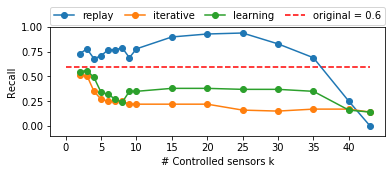

In [6]:
fig, ax = plt.subplots(figsize=(6,2))
ax.hlines(y=round(sum_orig/14,2),xmin=0, xmax=43, color='r', linestyles='--',)
ax.plot(results_attack.transpose(), 'o-')
plt.legend(np.append(results_attack.transpose().columns.values, 'original = '+str(round(sum_orig/14,2))),bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)
plt.xticks(np.arange(0, 43, 5.0))
plt.ylim(-0.1,1.0)
plt.xlabel('# Controlled sensors k')
plt.ylabel('Recall')
plt.savefig('plot_recall_BATADAL.pdf', bbox_inches = "tight")
plt.show()

In [7]:
results_attack.to_latex()

'\\begin{tabular}{lllllllllllllllll}\n\\toprule\n{} &    43 &    40 &    35 &    30 &    25 &    20 &    15 &    10 &    9  &    8  &    7  &    6  &    5  &    4  &    3  &    2  \\\\\n\\midrule\nreplay    &     0 &  0.25 &  0.69 &  0.83 &  0.94 &  0.93 &   0.9 &  0.78 &  0.69 &  0.79 &  0.77 &  0.77 &  0.71 &  0.68 &  0.78 &  0.73 \\\\\niterative &  0.14 &  0.17 &  0.17 &  0.15 &  0.16 &  0.22 &  0.22 &  0.22 &  0.22 &  0.25 &  0.25 &  0.25 &  0.27 &  0.35 &  0.51 &  0.52 \\\\\nlearning  &  0.14 &  0.16 &  0.35 &  0.37 &  0.37 &  0.38 &  0.38 &  0.35 &  0.35 &  0.24 &  0.27 &  0.32 &  0.34 &  0.49 &  0.56 &  0.55 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [8]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y
A = [40, results_attack[40]['iterative']]
B = [43, results_attack[43]['iterative']]
C = [40, results_attack[40]['replay']]
D = [43, results_attack[43]['replay']]
#print(line_intersection((A,B), (C, D)))
x, _ = line_intersection((A,B), (C, D))
print(round(x/43,2))

0.96


# Evaluate Constrained Attack over D dimension

In [9]:
results_mean_percentage_reduced = {new_list: [] for new_list in [5, 10, 25, 50, 75]}#['5%', '10%', '25%', '50%', '75%']}
results_percentage_reduced = {}
accuracy = {}
for percentage in [5, 10, 25, 50, 75]:
    accuracy[percentage] = {}
    for seed in [0, 1, 12, 123, 1234, 12345, 123456, 1234567, 12345678, 123456789]:
        for i in range(1,15):
            dataset = pd.read_csv('../Adversarial_Attacks/Black_Box_Attack/results/BATADAL/AE_'+str(percentage)
                                    +'_percent/seed_'+str(seed)+'/new_advAE_attack_'+str(i)+'_from_test_dataset.csv'
                                    , dayfirst=True)
            dataset = pd.DataFrame(index=dataset.index, columns=xset,
                      data=scaler.transform(dataset[xset]))
            Y7  = [1]*len(dataset)
            Yhat7, _, _, _ = autoencoder.detect(dataset, theta=theta, window=3, average=True)
            
            results = pd.DataFrame(
                           columns=['accuracy', 'f1_score', 'precision', 'recall'])
            results.loc['percentage'] = compute_scores(Y7, Yhat7) 
            
            #mean.append()
            
            try:
                  accuracy[percentage]['att_'+str(i)].append(results.loc['percentage'].at['recall'])                              
            except:
                accuracy[percentage]['att_'+str(i)] = []
                accuracy[percentage]['att_'+str(i)].append(results.loc['percentage'].at['recall'])
    mean=[]
    std = []
    for i in range(1,15):
        mean.append(np.mean(accuracy[percentage]['att_'+str(i)]))
        std.append(np.std(accuracy[percentage]['att_'+str(i)]))
    
    results_mean_percentage_reduced[percentage].append(np.mean(mean))
    results_mean_percentage_reduced[percentage].append(np.mean(std))

results_mean_percentage_reduced=pd.DataFrame.from_dict(results_mean_percentage_reduced, orient='index', columns = ['mean', 'std'])

In [10]:
print("Recall after Constrained Attack over D Dimension")
results_mean_percentage_reduced.round(2)

Recall after Constrained Attack over D Dimension


,mean,std
5,0.22,0.09
10,0.25,0.09
25,0.16,0.03
50,0.15,0.02
75,0.15,0.02
